## Packages

In [59]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Loading the data

In [60]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", 
                              end = "2019-09-01", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [61]:
df_comp = raw_data.copy()

In [62]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [63]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

## Creating Returns

In [64]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

In [65]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

## Splitting the Data

In [66]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## Fitting a Model

In [67]:
model_ar = ARIMA(df.ftse, order=(1,0,0))
results_ar = model_ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 5352
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -29376.023
Date:                Mon, 01 Aug 2022   AIC                          58758.045
Time:                        20:24:07   BIC                          58777.801
Sample:                    01-10-1994   HQIC                         58764.946
                         - 07-15-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5184.5182    461.249     11.240      0.000    4280.487    6088.549
ar.L1          0.9986      0.001   1219.381      0.000       0.997       1.000
sigma2      3424.0355     38.543     88.837      0.000    3348.493    3499.578
===================================================================================
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):              3570.83
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Simple Forecasting

In [68]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2014-07-09,1972.829956,9808.200195,6718.000000,15302.650391,0.464427,-0.304222,0.363568,-0.076789,-193.623849,39.056133,260.939581,-33.873062
2014-07-10,1964.680054,9659.129883,6672.399902,15216.469727,-0.413107,-0.678775,-1.519854,-0.563175,172.228229,87.141370,-1090.828512,-248.427258
2014-07-11,1967.569946,9666.339844,6690.200195,15164.040039,0.147092,0.266775,0.074644,-0.344559,-61.324138,-34.248669,53.573442,-151.991545
2014-07-14,1977.099976,9783.009766,6746.100098,15296.820312,0.484355,0.835549,1.206971,0.875626,-201.932230,-107.268090,866.266436,386.255523
2014-07-15,1973.280029,9719.410156,6710.500000,15395.160156,-0.193210,-0.527714,-0.650103,0.642878,80.550866,67.748084,-466.591262,283.585757


In [69]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = '2014-07-15'
end_date = '2015-01-01'

In [70]:
df_pred = results_ar.predict(start=start_date, end=end_date)

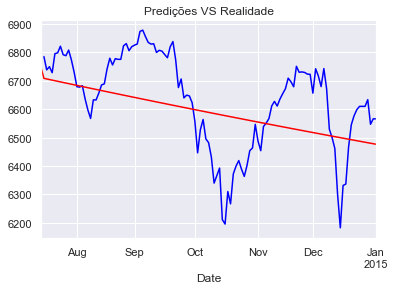

In [71]:
df_test.ftse[start_date:end_date].plot(color="blue")
df_pred[start_date:end_date].plot(color="red")
plt.title("Predições VS Realidade")
plt.show()

### Using Returns Instead

In [72]:
model_ar = ARIMA(df.ret_ftse[1:], order=(1,0,0))
results_ar = model_ar.fit()

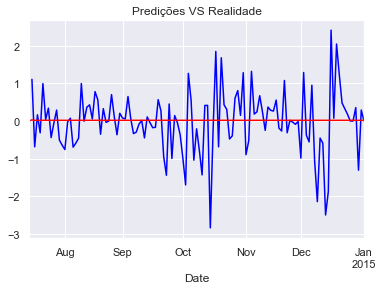

In [73]:
df_pred = results_ar.predict(start=start_date, end=end_date)
df_test.ret_ftse[start_date:end_date].plot(color="blue")
df_pred[start_date:end_date].plot(color="red")
plt.title("Predições VS Realidade")
plt.show()

### MA

In [74]:
model_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ma = model_ma.fit()

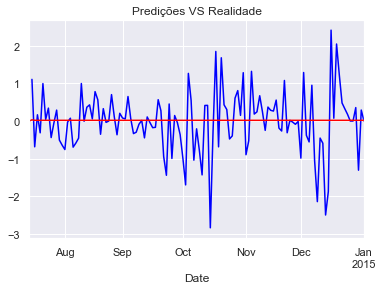

In [75]:
df_pred = results_ma.predict(start=start_date, end=end_date)
df_test.ret_ftse[start_date:end_date].plot(color="blue")
df_pred[start_date:end_date].plot(color="red")
plt.title("Predições VS Realidade")
plt.show()

### ARMA

In [76]:
model_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_arma = model_arma.fit()

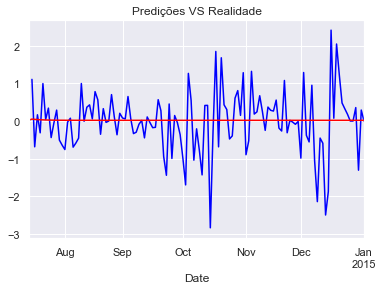

In [77]:
df_pred = results_arma.predict(start=start_date, end=end_date)
df_test.ret_ftse[start_date:end_date].plot(color="blue")
df_pred[start_date:end_date].plot(color="red")
plt.title("Predições VS Realidade")
plt.show()

### ARMAX

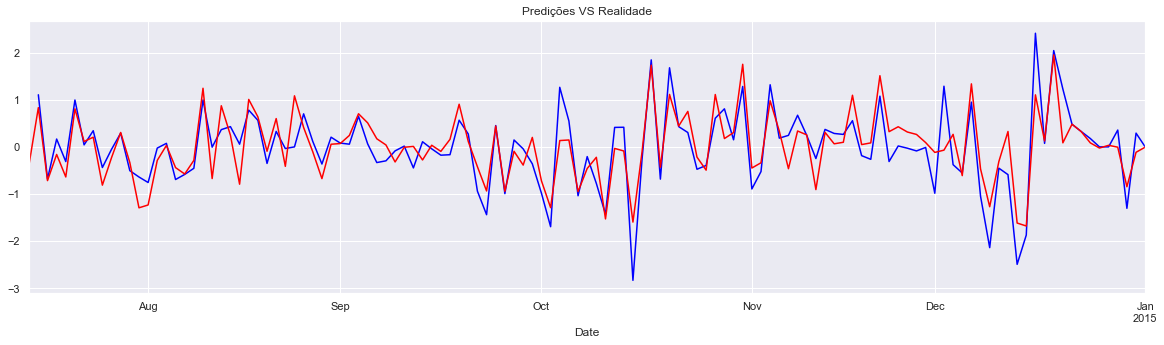

In [78]:
model_armax = ARIMA(df.ret_ftse[1:], order=(1,0,1), exog=df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:])
results_armax = model_armax.fit()

df_pred = results_armax.predict(start=start_date, end=end_date, exog=df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])
df_test.ret_ftse[start_date:end_date].plot(color="blue", figsize=(20, 5))
df_pred[start_date:end_date].plot(color="red")
plt.title("Predições VS Realidade")
plt.show()

### SARMA

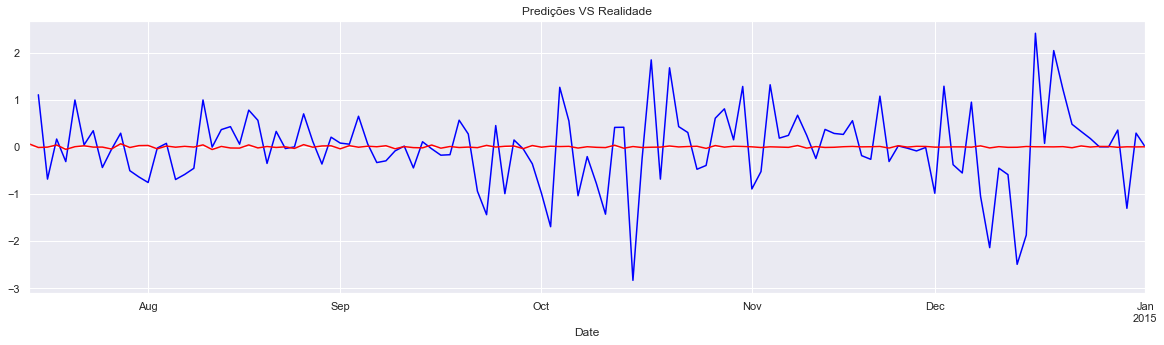

In [79]:
model_sarma = SARIMAX(df.ret_ftse[1:], order=(3,0,4), seasonal_order=(3,0,2,5))
results_sarma = model_sarma.fit()

df_pred = results_sarma.predict(start=start_date, end=end_date)
df_test.ret_ftse[start_date:end_date].plot(color="blue", figsize=(20, 5))
df_pred[start_date:end_date].plot(color="red")
plt.title("Predições VS Realidade")
plt.show()

### SARIMAX

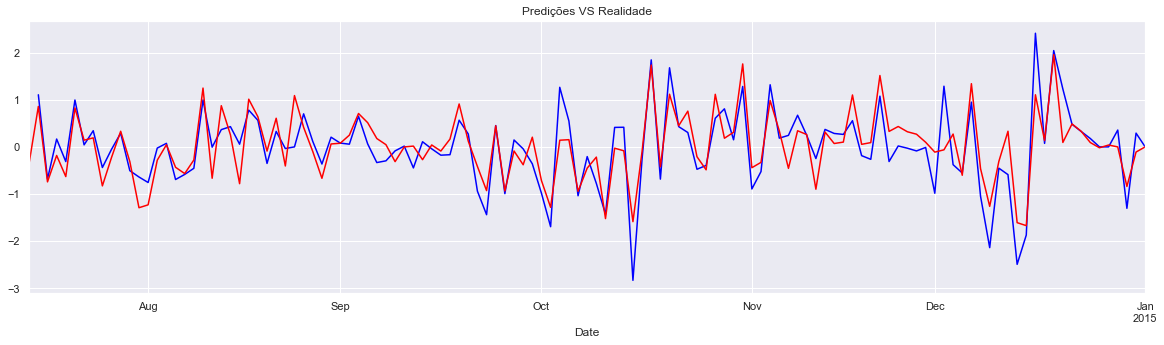

In [80]:
model_sarimax = SARIMAX(df.ret_ftse[1:], order=(3,0,4), seasonal_order=(3,0,2,5), exog=df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:])
results_sarimax = model_sarimax.fit()

df_pred = results_sarimax.predict(start=start_date, end=end_date, exog=df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])
df_test.ret_ftse[start_date:end_date].plot(color="blue", figsize=(20, 5))
df_pred[start_date:end_date].plot(color="red")
plt.title("Predições VS Realidade")
plt.show()

### Auto ARIMA

In [ ]:
model_auto = auto_arima(df.ret_ftse[1:], X=df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], m=5, max_p=5,max_q=5,max_P=5, max_Q=5)

In [ ]:
df_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date])X=df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:]), index=df_test[start_date:end_date].index)

In [ ]:
df_pred[start_date:end_date].plot(color="red")
df_test.ret_ftse[start_date:end_date].plot(color="blue", figsize=(20, 5))
plt.title("Predições VS Realidade")
plt.show()

### Comparing All the Models (Returns)

### Forecasting Volatility

In [81]:
mod_garch = arch_model(df_comp.ret_ftse[1:], vol='GARCH', p=1, q=1, mean='constant', dist='Normal')
res_garch = mod_garch.fit(last_obs=start_date)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 197945317941589.75
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2873783049.892271
Iteration:      3,   Func. Count:     23,   Neg. LLF: 7349.03630444159
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7377.379049873645
Iteration:      5,   Func. Count:     35,   Neg. LLF: 7348.414286116549
Iteration:      6,   Func. Count:     41,   Neg. LLF: 7315.474797589836
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7406.573379651237
Iteration:      8,   Func. Count:     53,   Neg. LLF: 7313.968101253335
Iteration:      9,   Func. Count:     59,   Neg. LLF: 7309.815164167982
Iteration:     10,   Func. Count:     65,   Neg. LLF: 7309.738663281408
Iteration:     11,   Func. Count:     70,   Neg. LLF: 7309.738653886703
Iteration:     12,   Func. Count:     74,   Neg. LLF: 7309.738653886463
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7309.738653886703
            Iterations: 12
 

In [82]:
pred_garch = res_garch.forecast(horizon=1, align='target')

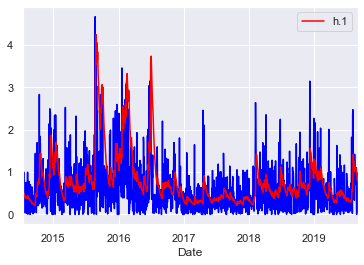

In [86]:
pred_garch.residual_variance[start_date:].plot(color='red', zorder=2)
df_test.ret_ftse.abs().plot(color='blue', zorder=1)
plt.show()

### Multvariate Regression Model